In [ ]:
import numpy as np
import nibabel as nb
import glob
import matplotlib.pyplot as plt
import cv2
import h5py
import os
import random
from tqdm import tqdm
## the directory with datatset
root_dir = "training/*/*"

files = glob.glob(root_dir)
labels = []
images = []
test_list = [random.randint(1,101) for _ in range(20)]#
test_list = list(map(lambda x: str(x).zfill(3), test_list))
for each in files:
    if "frame" in each and "gt" in each:
        labels.append(each)
    elif "frame" in each:
        images.append(each)

os.makedirs('/root/data/ACDC/train_npz',exist_ok=True)
os.makedirs('/root/data/ACDC/test_npz',exist_ok=True)
os.makedirs('/root/data/ACDC/test_vol_h5',exist_ok=True)
os.makedirs('/root/Swin-Unet/lists/lists_ACDC/',exist_ok=True)
prev_patient = "patient001"
slice_num = 0
train_file = open('/root/Swin-Unet/lists/lists_ACDC/train.txt','w')
test_file = open('/root/Swin-Unet/lists/lists_ACDC/test.txt','w')
test_h5_file = open('/root/Swin-Unet/lists/lists_ACDC/test_vol.txt','w')
for i in tqdm(range(len(images))):
    slice_num=0
    patient = images[i].split("/")[-2]
    image = nb.load(images[i]).get_fdata()
    label = nb.load(labels[i]).get_fdata()
    image = (image-image.min())/(image.max()-image.min())
    size = image.shape
    if size[0]>size[1]:
        pad_left = (size[0]-size[1])//2+(size[0]-size[1])%2
        pad_right = (size[0]-size[1])//2
        image = np.pad(image,((0,0),(pad_left,pad_right),(0,0)),'constant')
        label = np.pad(label,((0,0),(pad_left,pad_right),(0,0)),'constant')
    elif size[0]<size[1]:
        pad_up = (size[1]-size[0])//2+(size[1]-size[0])%2
        pad_down = (size[1]-size[0])//2
        image = np.pad(image,((pad_up,pad_down),(0,0),(0,0)),'constant')
        label = np.pad(label,((pad_up,pad_down),(0,0),(0,0)),'constant')
        
    assert image.shape[0]==image.shape[1],'padding failed'
    assert image.shape[2]==label.shape[2],f'{image.shape[2],label.shape[2],images[i],labels[i]}'
    slices = image.shape[2]
    if i!=0 and prev_patient == patient:
        slice_num = slice_num +slices
    if patient[-3:] not in test_list:
        for num in range(slices):
            case_image = cv2.resize(image[:,:,num],(224,224),interpolation=cv2.INTER_NEAREST)
            case_label = cv2.resize(label[:,:,num],(224,224),interpolation=cv2.INTER_NEAREST)
            np.savez("/root/data/ACDC/train_npz/" + str(patient) + "_slice" + str(slice_num).zfill(3),image = case_image, label=case_label)
            train_file.write(str(patient) + "_slice" + str(slice_num).zfill(3)+'.npz'+'\n')
            slice_num+=1
    else:
        image_h5, label_h5 = np.zeros((slices, 224, 224)), np.zeros((slices, 224, 224))
        for num in range(slices):
            case_image = cv2.resize(image[:,:,num],(224,224),interpolation=cv2.INTER_NEAREST)
            case_label = cv2.resize(label[:,:,num],(224,224),interpolation=cv2.INTER_NEAREST)
            image_h5[num], label_h5[num] = case_image, case_label
            np.savez("/root/data/ACDC/test_npz/" + str(patient) + "_slice" + str(slice_num).zfill(3),image = case_image, label=case_label)
            test_file.write(str(patient) + "_slice" + str(slice_num).zfill(3)+'.npz'+'\n')
            slice_num+=1
        with h5py.File(f"/root/data/ACDC/test_vol_h5/{patient}.npy.h5", 'w') as f:
            f.create_dataset('image', data=image_h5)
            f.create_dataset('label', data=label_h5)
        test_h5_file.write(f'{patient}.npy.h5'+'\n')
            
    prev_patient = patient
train_file.close()
test_file.close()
test_h5_file.close()

[0. 1. 4.]


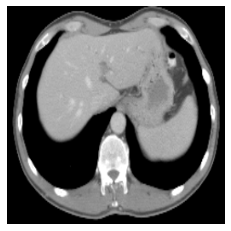

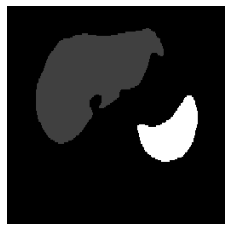

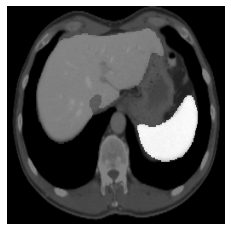

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
data = np.load('/root/data/Synapse/train_npz/case0005_slice080.npz')
image, label = data['image'], data['label']
print(np.unique(label))
image1 = (image * 255).astype(np.uint8)
label1 = (label*255).astype(np.uint8)
plt.imshow(image,'gray')
plt.axis('off')
plt.show()
plt.imshow(label,'gray')
plt.axis('off')
plt.show()
image_label = image+label
plt.imshow(image_label,'gray')
plt.axis('off')
plt.show()

In [ ]:
# import os
# import h5py
# import numpy as np
# PATH = '/root/data/Synapse/test_vol_h5'
# file = open('/root/Swin-Unet/lists/lists_Synapse/test.txt','w')
# idx = 0
# for path in os.listdir(PATH):
#     if path=='.ipynb_checkpoints':
#         continue
#     data = h5py.File(os.path.join(PATH,path),'r')
#     images, labels = data['image'][:], data['label'][:]
#     for img, lal in zip(images,labels):
#         np.savez(f'/root/data/Synapse/test_npz/case{idx}.npz',image=img,label=lal)
#         file.write(f'case{idx}.npz'+'\n')
#         idx+=1
# file.close()
            